In [1]:
from os import chdir
chdir('..')

In [36]:
# import matplotlib.pyplot as plt
import seaborn as sns
from seaborn.relational import _LinePlotter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
%matplotlib notebook
sns.set(font_scale=1.1)
current_palette = sns.color_palette()

In [3]:
df = pd.read_csv('./test_fixtures/results/all_timings.csv')
df = df.replace('migloveholes', 'miglove')
df = df.replace('hiholes', 'hi')
df = df.replace('caholes', 'ca')
df_all_section = df[df.section == 'all']
df_all_poly_cgal = df_all_section[df_all_section.alg.isin(['polylidar', 'cgal'])]
df_all_poly_cgal_spatialite = df_all_section[df_all_section.alg.isin(['polylidar', 'cgal', 'spatialite'])]
df_pl = df[df.alg == 'polylidar']
df_pl_sec = df_pl[df_pl.section != 'all']
df.head()

,alg,holes,l2_norm,points,section,shape,time
0,polylidar,True,NaN,8000,delaunay,ca,4.945
1,polylidar,True,NaN,8000,delaunay,ca,3.618
2,polylidar,True,NaN,8000,delaunay,ca,3.520
3,polylidar,True,NaN,8000,delaunay,ca,3.350
4,polylidar,True,NaN,8000,delaunay,ca,3.713


In [4]:
def add_proper_legend(p, ax):
    p.legend='brief'
    p.add_legend_data(ax)
    legend_data = dict(p.legend_data)
    # Delete the parts of the legend we dont want
    for to_del in [True, False, 'alg', 'holes']:
        del legend_data[to_del]
    # Create the legend
    labels, handles = list(zip(*legend_data.items()))
    ax.legend(handles, labels)

def plot_time(df, df_inset, inset_axes=(0.75,0.35,.3,.25), inset_limits=(50000, 64000, 0, 500)):
    line_kwargs = dict(estimator="mean", ci=95, n_boot=1000, dashes=True,
             sort=True, err_style="band", err_kws=None)
    
    palette = {'polylidar': current_palette[0], 'cgal': current_palette[1], 'postgis': current_palette[2], 'spatialite': current_palette[3]}

    p = _LinePlotter(x="points", y="time", hue="alg", style='holes',legend='brief', data=df, palette=palette, **line_kwargs)
    ax = plt.gca()
    p.plot(ax, {})
    # Hacky way to create the legend that we want
    # have seaborn get the artist handles
    add_proper_legend(p, ax)


    ax.set_ylabel("time (ms)")
    ax.set_xlabel("# Points")
    ax.set_title('')
    # ax = g.facet_axis(0,0)
    ax.set_xlim([0, 70000])

    # Add inset zoomed in axes
    axins = ax.inset_axes(inset_axes)
    # axins = zoomed_inset_axes(ax,1.0,loc=1) # zoom=6
    x1,x2,y1,y2 = inset_limits
    axins.set_xlim(x1,x2)
    axins.set_ylim(y1,y2)
    axins.set_xticks([])
    axins.set_yticks([0, 200, 400])
    axins.yaxis.tick_right()

    mark_inset(ax, axins, loc1=4, loc2=3, fc="none", ec="0.3")
    sns.lineplot(x='points', y='time', hue='alg', style='holes', legend=False, data=df_inset, ax=axins)
    axins.set_xlabel('')
    axins.set_ylabel('')
    for spine in axins.spines.values():
        spine.set_edgecolor('0.3')
        
def plot_error(df, y_lim=[0, 0.12]):
    line_kwargs = dict(estimator="mean", ci=95, n_boot=1000, dashes=True,
                        sort=True, err_style="band", err_kws=None)
    palette = {'polylidar/cgal': current_palette[0], 'postgis': current_palette[2], 'spatialite': current_palette[3]}

    p = _LinePlotter(x="points", y="l2_norm", hue="alg", style='holes', palette=palette, legend=False, data=df, **line_kwargs)
    ax = plt.gca()
    p.plot(ax, {})
    add_proper_legend(p, ax)

    ax.set_title('')
    ax.set_ylabel(r'$L^2$ error')
    ax.set_xlabel("# Points")
    ax.set_ylim(y_lim)

    

# MI

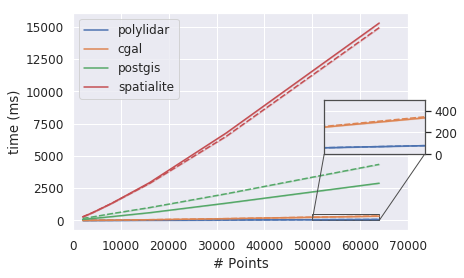

In [5]:
plt.close(plt.gcf())
df_mi = df_all_section[df_all_section['shape'].isin(['miglove'])]
df_mi_poly_cgal = df_all_poly_cgal[df_all_poly_cgal['shape'].isin(['miglove'])]
plot_time(df_mi, df_mi_poly_cgal)

plt.savefig('assets/pics/compare_algs_time_inset_mi.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


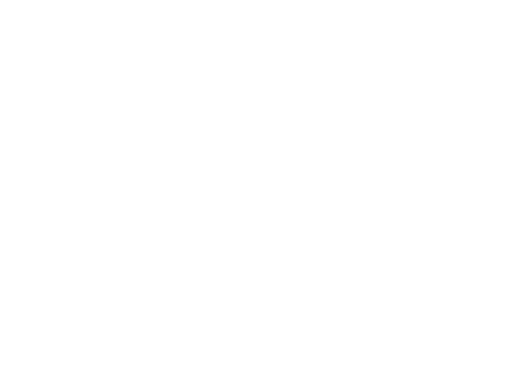

<IPython.core.display.Javascript object>


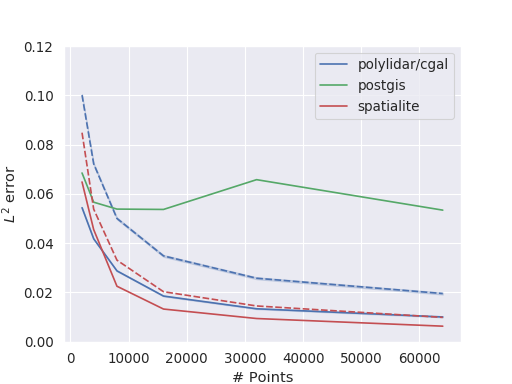

In [38]:
plt.close(plt.gcf())
df_all_section_comb_poly_cgal =  df_mi.replace('polylidar', 'polylidar/cgal')
df_all_section_comb_poly_cgal =  df_all_section_comb_poly_cgal.replace('cgal', 'polylidar/cgal')

plot_error(df_all_section_comb_poly_cgal)

plt.savefig('assets/pics/compare_algs_accuracy_mi.pdf', bbox_inches='tight')
# g.set(yscale="log")

In [7]:
df_mi_means = df_mi.groupby(['points', 'alg'])[['time', 'l2_norm']].mean()
df_mi_means = df_mi_means.reset_index()
df_p = df_mi_means.pivot(index='alg', columns='points', values=['l2_norm']).round(3) * 100
df_p.reindex(["polylidar", "cgal", "postgis", 'spatialite'])

l2_norm                              
points       2000  4000  8000  16000 32000 64000
alg                                             
polylidar      7.8   5.7   4.0   2.7   2.0   1.5
cgal           7.7   5.7   3.9   2.6   1.9   1.5
postgis       15.2  14.1  13.0  13.9  14.4  13.9
spatialite     7.5   5.0   2.8   1.7   1.2   0.8

# CA

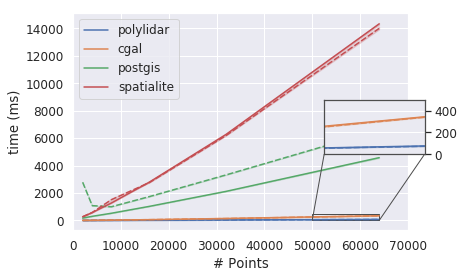

In [8]:
plt.close(plt.gcf())
df_ca = df_all_section[df_all_section['shape'].isin(['ca'])]
df_ca_poly_cgal = df_all_poly_cgal[df_all_poly_cgal['shape'].isin(['ca'])]
plot_time(df_ca, df_ca_poly_cgal)

plt.savefig('assets/pics/compare_algs_time_inset_ca.pdf', bbox_inches='tight')

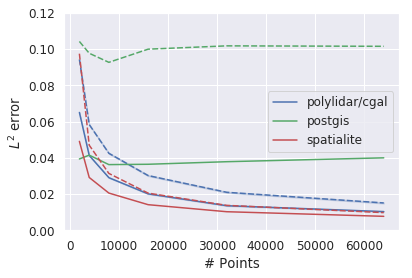

In [9]:
plt.close(plt.gcf())
df_all_section_comb_poly_cgal =  df_ca.replace('polylidar', 'polylidar/cgal')
df_all_section_comb_poly_cgal =  df_all_section_comb_poly_cgal.replace('cgal', 'polylidar/cgal')

plot_error(df_all_section_comb_poly_cgal)

plt.savefig('assets/pics/compare_algs_accuracy_ca.pdf', bbox_inches='tight')
# g.set(yscale="log")

# HI

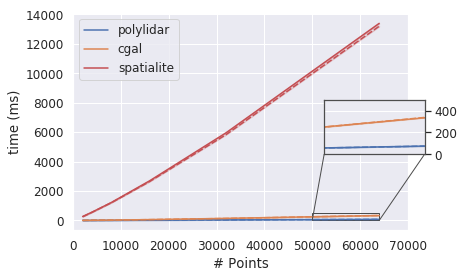

In [10]:
plt.close(plt.gcf())
df_hi = df_all_poly_cgal_spatialite[df_all_poly_cgal_spatialite['shape'].isin(['hi'])]
df_hi_poly_cgal = df_all_poly_cgal[df_all_poly_cgal['shape'].isin(['hi'])]
plot_time(df_hi, df_hi)

plt.savefig('assets/pics/compare_algs_time_inset_hi.pdf', bbox_inches='tight')

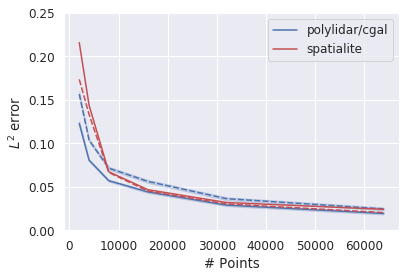

In [11]:
plt.close(plt.gcf())
df_all_section_comb_poly_cgal =  df_hi.replace('polylidar', 'polylidar/cgal')
df_all_section_comb_poly_cgal =  df_all_section_comb_poly_cgal.replace('cgal', 'polylidar/cgal')

plot_error(df_all_section_comb_poly_cgal, y_lim=[0, 0.250])

plt.savefig('assets/pics/compare_algs_accuracy_hi.pdf', bbox_inches='tight')

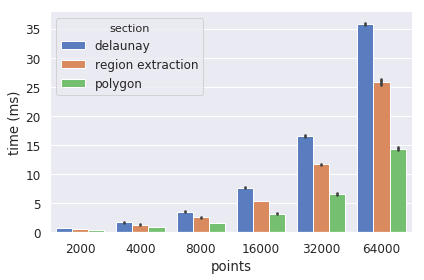

In [12]:
fig = plt.Figure((5,5))
df_pl_sec = df_pl_sec.replace('mesh', 'region extraction')
g = sns.catplot(x="points", y="time", hue="section", data=df_pl_sec, kind="bar", palette="muted",
                hue_order=["delaunay", "region extraction", "polygon"],  height=4, aspect=1.5, legend_out=False)

g.set_ylabels("time (ms)")
g.savefig('assets/pics/polylidar_decomposed.pdf')
# g.set(yscale="log")
# g.savefig("imgs/timing_results.pdf")

In [13]:
df_pl_sec_miglove = df_pl_sec[df_pl_sec['shape'] == 'miglove']

df_new = df_pl_sec_miglove.groupby([df_pl_sec_miglove['section'], df_pl_sec_miglove['points']]).mean()
df_new = df_new.reset_index()
df_delaunay = df_new[df_new['section'] == 'delaunay']
df_mesh = df_new[df_new['section'] == 'mesh']
df_polygon = df_new[df_new['section'] == 'polygon']

delaunay_diff = df_delaunay['time'].pct_change().reset_index()
mesh_diff = df_mesh['time'].pct_change().reset_index()
polygon_diff = df_polygon['time'].pct_change().reset_index()

values = []
names = ['delaunay_PctChange', 'mesh_PctChange', 'polygon_PctChange']
values.append(delaunay_diff.values[1:,1])
values.append(mesh_diff.values[1:, 1])
values.append(polygon_diff.values[1:, 1])

pd.DataFrame.from_items(zip(names, values))



/home/jeremy/miniconda3/envs/concave/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


# Alphabet Comparison

In [167]:
df = pd.read_csv('./test_fixtures/results/alphabet_results.csv')
df.head(n=10)

,alg,convexity,holes,l2_norm,points,section,shape,time
0,polylidar,0.464088,True,0.135555,2000,all,A,2.858000
1,cgal,0.464088,True,0.133860,2000,all,A,7.348000
2,spatialite,0.464088,True,0.133987,2000,all,A,364.209890
3,postgis,0.464088,True,0.254662,2000,all,A,6280.151129
4,polylidar,0.457297,True,0.137405,2000,all,B,1.597000
5,cgal,0.457297,True,0.135875,2000,all,B,6.119000
6,spatialite,0.457297,True,0.097786,2000,all,B,339.827299
7,postgis,0.457297,True,0.372216,2000,all,B,7114.272833
8,polylidar,0.315637,False,0.114009,2000,all,C,1.766000
9,cgal,0.315637,False,0.112247,2000,all,C,6.461000


In [168]:
# CGAL accuracy is the SAME as Polylidar (same alpha, same shape). These small numerical differences are inadvertantly introduced
# when I convert the unsorted edges of CGAL into a polygon. I use a very small buffer to the edges causing them to be slightly
# bigger than they the true shape returned. 
# I am overwriting the l2 norm of CGAL with Polylidar because that is the TRUE accuracy (of the unmodified edges returned from CGAL)

cgal_indices = df.index[df['alg'] == 'cgal']
df.loc[cgal_indices, "l2_norm"] = df[df['alg'] == 'polylidar']['l2_norm'].values
df.head(n=10)

,alg,convexity,holes,l2_norm,points,section,shape,time
0,polylidar,0.464088,True,0.135555,2000,all,A,2.858000
1,cgal,0.464088,True,0.135555,2000,all,A,7.348000
2,spatialite,0.464088,True,0.133987,2000,all,A,364.209890
3,postgis,0.464088,True,0.254662,2000,all,A,6280.151129
4,polylidar,0.457297,True,0.137405,2000,all,B,1.597000
5,cgal,0.457297,True,0.137405,2000,all,B,6.119000
6,spatialite,0.457297,True,0.097786,2000,all,B,339.827299
7,postgis,0.457297,True,0.372216,2000,all,B,7114.272833
8,polylidar,0.315637,False,0.114009,2000,all,C,1.766000
9,cgal,0.315637,False,0.114009,2000,all,C,6.461000


<IPython.core.display.Javascript object>


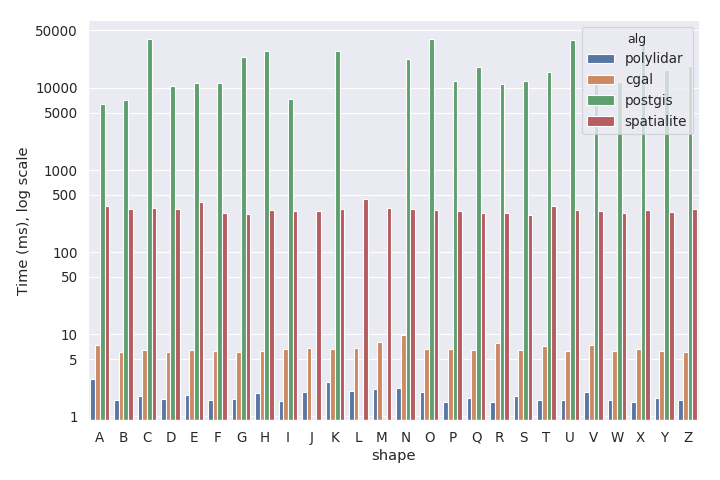

In [156]:
# Draw a nested barplot to show survival for class and sex
ticks = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000]
labels = [i for i in ticks]
order = ['polylidar', 'cgal', 'postgis', 'spatialite']
# df_ = df[df['alg'].isin(['polylidar', 'cgal', 'spatialite'])]
g = sns.catplot(x="shape", y="time", hue="alg", data=df,
                height=6, kind="bar", aspect=1.5, hue_order=order, legend_out=False)
# g.despine(left=True)
g.set(yscale = 'log')
g.set(yticks = ticks, yticklabels = labels)
g.set_ylabels("Time (ms), log scale")
g.savefig('assets/pics/alphabet_time.pdf')

<IPython.core.display.Javascript object>


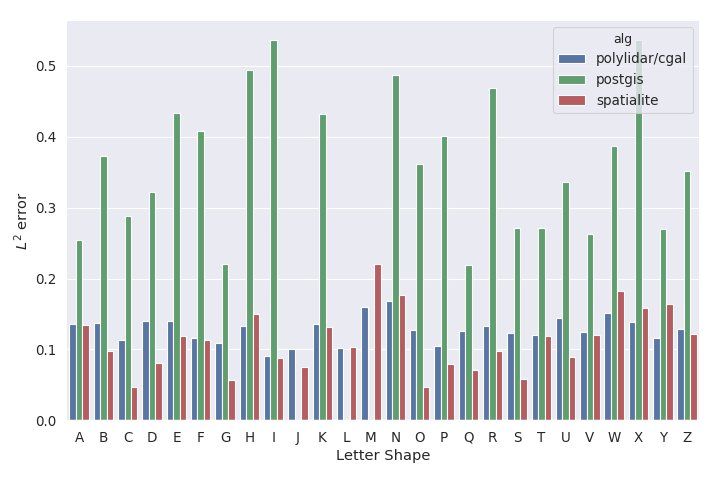

In [157]:
# Polylidar and cgal have the same l2 error
df_ =  df.replace('polylidar', 'polylidar/cgal')
df_ =  df_[df_['alg'].isin(['polylidar/cgal', 'postgis', 'spatialite'])]

order = ['polylidar/cgal', 'postgis', 'spatialite']
palette = {'polylidar/cgal': current_palette[0], 'postgis': current_palette[2], 'spatialite': current_palette[3]}
# df_ = df[df['alg'].isin(['polylidar', 'cgal', 'spatialite'])]
g = sns.catplot(x="shape", y="l2_norm", hue="alg", data=df_,
                height=6, kind="bar", palette=palette, aspect=1.5, hue_order=order, legend_out=False)
g.despine(left=True)
# g.set(yscale = 'log')
# g.set(yticks = ticks, yticklabels = labels)
g.set_ylabels(r'$L^2$ error')
g.set_xlabels("Letter Shape")
g.savefig('assets/pics/alphabet_accuracy.pdf')

## Alphabet Table

In [158]:
df_result = df.groupby(['shape', 'alg']).agg(
    {'l2_norm':['mean','std', 'max'],'time':['mean', 'std', 'max']})
df_result= df_result.rename(columns={"l2_norm": "$L^2\%$", "time": "time (ms)"})
# df_result = df_result.reindex(['very hi','hi', 'mid', 'low'], level='$C$')
# print(df_result.to_latex(escape=False, float_format="%.1f"))
df_result

$L^2\%$                   time (ms)                  
                      mean std       max          mean std           max
shape alg                                                               
A     cgal        0.135555 NaN  0.135555      7.348000 NaN      7.348000
      polylidar   0.135555 NaN  0.135555      2.858000 NaN      2.858000
      postgis     0.254662 NaN  0.254662   6280.151129 NaN   6280.151129
      spatialite  0.133987 NaN  0.133987    364.209890 NaN    364.209890
B     cgal        0.137405 NaN  0.137405      6.119000 NaN      6.119000
      polylidar   0.137405 NaN  0.137405      1.597000 NaN      1.597000
      postgis     0.372216 NaN  0.372216   7114.272833 NaN   7114.272833
      spatialite  0.097786 NaN  0.097786    339.827299 NaN    339.827299
C     cgal        0.114009 NaN  0.114009      6.461000 NaN      6.461000
      polylidar   0.114009 NaN  0.114009      1.766000 NaN      1.766000
      postgis     0.288218 NaN  0.288218  39168.134689 NaN  39168.134689
      spatialite  0.047138 NaN  0.047138    341.684818 NaN    341.684818
D     cgal        0.140256 NaN  0.140256      6.154000 NaN      6.154000
      polylidar   0.140256 NaN  0.140256      1.621000 NaN      1.621000
      postgis     0.321616 NaN  0.321616  10648.947239 NaN  10648.947239
      spatialite  0.080481 NaN  0.080481    332.854033 NaN    332.854033
E     cgal        0.140251 NaN  0.140251      6.417000 NaN      6.417000
      polylidar   0.140251 NaN  0.140251      1.845000 NaN      1.845000
      postgis     0.433199 NaN  0.433199  11526.370049 NaN  11526.370049
      spatialite  0.119630 NaN  0.119630    403.110504 NaN    403.110504
F     cgal        0.116335 NaN  0.116335      6.189000 NaN      6.189000
      polylidar   0.116335 NaN  0.116335      1.583000 NaN      1.583000
      postgis     0.408250 NaN  0.408250  11405.699968 NaN  11405.699968
      spatialite  0.112803 NaN  0.112803    295.900106 NaN    295.900106
G     cgal        0.109655 NaN  0.109655      6.121000 NaN      6.121000
      polylidar   0.109655 NaN  0.109655      1.650000 NaN      1.650000
      postgis     0.219907 NaN  0.219907  23641.631365 NaN  23641.631365
      spatialite  0.056624 NaN  0.056624    293.632507 NaN    293.632507
H     cgal        0.133344 NaN  0.133344      6.344000 NaN      6.344000
      polylidar   0.133344 NaN  0.133344      1.951000 NaN      1.951000
...                    ...  ..       ...           ...  ..           ...
S     postgis     0.271116 NaN  0.271116  12075.000286 NaN  12075.000286
      spatialite  0.058653 NaN  0.058653    284.429312 NaN    284.429312
T     cgal        0.120435 NaN  0.120435      7.197000 NaN      7.197000
      polylidar   0.120435 NaN  0.120435      1.580000 NaN      1.580000
      postgis     0.270832 NaN  0.270832  15560.969591 NaN  15560.969591
      spatialite  0.119206 NaN  0.119206    362.988472 NaN    362.988472
U     cgal        0.144231 NaN  0.144231      6.229000 NaN      6.229000
      polylidar   0.144231 NaN  0.144231      1.587000 NaN      1.587000
      postgis     0.336293 NaN  0.336293  38590.739250 NaN  38590.739250
      spatialite  0.088868 NaN  0.088868    326.612949 NaN    326.612949
V     cgal        0.124820 NaN  0.124820      7.416000 NaN      7.416000
      polylidar   0.124820 NaN  0.124820      1.970000 NaN      1.970000
      postgis     0.262378 NaN  0.262378  12109.718323 NaN  12109.718323
      spatialite  0.120819 NaN  0.120819    319.292784 NaN    319.292784
W     cgal        0.150889 NaN  0.150889      6.267000 NaN      6.267000
      polylidar   0.150889 NaN  0.150889      1.585000 NaN      1.585000
      postgis     0.387041 NaN  0.387041  11793.530464 NaN  11793.530464
      spatialite  0.182041 NaN  0.182041    297.976017 NaN    297.976017
X     cgal        0.138296 NaN  0.138296      6.631000 NaN      6.631000
      polylidar   0.138296 NaN  0.138296      1.495000 NaN      1.495000
      postgis     0.536506 NaN  0.536506  34895.683765 NaN  34895.683765
    

In [159]:
df_result = df.pivot(index='shape', columns='alg', values=['l2_norm', 'time'])
column_order = ['polylidar', 'cgal', 'postgis', 'spatialite']
df_result = df_result.reindex(column_order, axis=1, level=1)
# df_result = df_result.drop('cgal', axis=1, level=1)
df_result
# print(df_result.to_latex(escape=False, float_format="%.2f"))

l2_norm                                     time                       \
alg   polylidar      cgal   postgis spatialite polylidar   cgal       postgis   
shape                                                                           
A      0.135555  0.135555  0.254662   0.133987     2.858  7.348   6280.151129   
B      0.137405  0.137405  0.372216   0.097786     1.597  6.119   7114.272833   
C      0.114009  0.114009  0.288218   0.047138     1.766  6.461  39168.134689   
D      0.140256  0.140256  0.321616   0.080481     1.621  6.154  10648.947239   
E      0.140251  0.140251  0.433199   0.119630     1.845  6.417  11526.370049   
F      0.116335  0.116335  0.408250   0.112803     1.583  6.189  11405.699968   
G      0.109655  0.109655  0.219907   0.056624     1.650  6.121  23641.631365   
H      0.133344  0.133344  0.494306   0.149491     1.951  6.344  27941.357374   
I      0.090254  0.090254  0.536804   0.088378     1.538  6.612   7238.083363   
J      0.100470  0.100470       NaN   0.075413     1.961  6.750           NaN   
K      0.135261  0.135261  0.431734   0.132344     2.642  6.553  27952.298880   
L      0.102380  0.102380       NaN   0.104100     2.044  6.836           NaN   
M      0.159733  0.159733       NaN   0.221086     2.131  7.949           NaN   
N      0.168214  0.168214  0.487505   0.177283     2.241  9.814  22412.108421   
O      0.127089  0.127089  0.360885   0.047098     2.004  6.667  39587.774754   
P      0.104338  0.104338  0.401345   0.079592     1.491  6.577  11993.089914   
Q      0.125628  0.125628  0.218797   0.070444     1.671  6.491  17806.192636   
R      0.133319  0.133319  0.468685   0.098078     1.515  7.750  11283.022881   
S      0.123636  0.123636  0.271116   0.058653     1.750  6.451  12075.000286   
T      0.120435  0.120435  0.270832   0.119206     1.580  7.197  15560.969591   
U      0.144231  0.144231  0.336293   0.088868     1.587  6.229  38590.739250   
V      0.124820  0.124820  0.262378   0.120819     1.970  7.416  12109.718323   
W      0.150889  0.150889  0.387041   0.182041     1.585  6.267  11793.530464   
X      0.138296  0.138296  0.536506   0.159025     1.495  6.631  34895.683765   
Y      0.116016  0.116016  0.269829   0.164383     1.689  6.265  16736.305475   
Z      0.128382  0.128382  0.351704   0.122160     1.587  6.173  18625.031948   

                   
alg    spatialite  
shape              
A      364.209890  
B      339.827299  
C      341.684818  
D      332.854033  
E      403.110504  
F      295.900106  
G      293.632507  
H      323.001146  
I      317.986250  
J      313.750029  
K      338.726759  
L      438.057899  
M      342.153072  
N      334.275723  
O      327.729464  
P      313.981295  
Q      296.230793  
R      299.795389  
S      284.429312  
T      362.988472  
U      326.612949  
V      319.292784  
W      297.976017  
X      329.952240  
Y      312.591553  
Z      339.784622

In [160]:
df1 = df_result["l2_norm"].drop('cgal', axis=1) * 100
df1 =df1.rename(columns=dict(polylidar='polylidar/cgal'))
df2 = df_result["time"] 

df_joined = pd.concat([df1,df2],axis=1,keys=['l2_norm','time'])
df_joined = df_joined.rename(columns={"l2_norm": "$L^2\%$", "time": "time (ms)", 'polylidar': 'PL', 'cgal':'CG',
                                        'postgis': 'PG', 'spatialite': 'SL', 'polylidar/cgal': 'PL/CG'})
print(df_joined.to_latex(escape=False, float_format="%.1f"))

\begin{tabular}{lrrrrrrr}
\toprule
{} & \multicolumn{3}{l}{$L^2\%$} & \multicolumn{4}{l}{time (ms)} \\
alg &   PL/CG &   PG &   SL &        PL &  CG &      PG &    SL \\
shape &         &      &      &           &     &         &       \\
\midrule
A     &    13.6 & 25.5 & 13.4 &       2.9 & 7.3 &  6280.2 & 364.2 \\
B     &    13.7 & 37.2 &  9.8 &       1.6 & 6.1 &  7114.3 & 339.8 \\
C     &    11.4 & 28.8 &  4.7 &       1.8 & 6.5 & 39168.1 & 341.7 \\
D     &    14.0 & 32.2 &  8.0 &       1.6 & 6.2 & 10648.9 & 332.9 \\
E     &    14.0 & 43.3 & 12.0 &       1.8 & 6.4 & 11526.4 & 403.1 \\
F     &    11.6 & 40.8 & 11.3 &       1.6 & 6.2 & 11405.7 & 295.9 \\
G     &    11.0 & 22.0 &  5.7 &       1.7 & 6.1 & 23641.6 & 293.6 \\
H     &    13.3 & 49.4 & 14.9 &       2.0 & 6.3 & 27941.4 & 323.0 \\
I     &     9.0 & 53.7 &  8.8 &       1.5 & 6.6 &  7238.1 & 318.0 \\
J     &    10.0 &  NaN &  7.5 &       2.0 & 6.8 &     NaN & 313.8 \\
K     &    13.5 & 43.2 & 13.2 &       2.6 & 6.6 & 27952.3 & 33

## Alphabet Aggregate

In [173]:
df[['l2_norm%']] = df[['l2_norm']] * 100
df_all = df.groupby(['alg']).agg(
    {'l2_norm%':['mean','std', 'max'],'time':['mean', 'std', 'max']})
column_order = ['polylidar', 'cgal', 'postgis', 'spatialite']

df_all = df_all.reindex(column_order, axis=0)
df_all = df_all.rename(columns={"l2_norm%": "$L^2$ error \%", "time": "time (ms)"})
df_all

$L^2$ error \%                          time (ms)                \
                     mean       std        max          mean           std   
alg                                                                          
polylidar       12.770007  1.830245  16.821447      1.821231      0.346447   
cgal            12.770007  1.830245  16.821447      6.760808      0.799805   
postgis         36.451419  9.883533  53.680355  18973.309330  10786.247640   
spatialite      11.180433  4.454599  22.108550    330.405189     33.848884   

                          
                     max  
alg                       
polylidar       2.858000  
cgal            9.814000  
postgis     39587.774754  
spatialite    438.057899

In [172]:
print(df_all.to_latex(escape=False, float_format="%.1f"))

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{$L^2\%$} & \multicolumn{3}{l}{time (ms)} \\
{} &    mean & std &  max &      mean &     std &     max \\
alg        &         &     &      &           &         &         \\
\midrule
polylidar  &    12.8 & 1.8 & 16.8 &       1.8 &     0.3 &     2.9 \\
cgal       &    12.8 & 1.8 & 16.8 &       6.8 &     0.8 &     9.8 \\
postgis    &    36.5 & 9.9 & 53.7 &   18973.3 & 10786.2 & 39587.8 \\
spatialite &    11.2 & 4.5 & 22.1 &     330.4 &    33.8 &   438.1 \\
\bottomrule
\end{tabular}

